In [1]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import joblib

# read file CSV
df = pd.read_csv(r'..\..\data\processed\filtered_data.csv')

def crop_and_resize_image(img_path, x1, y1, x2, y2, size=(128, 128)):
    img = cv2.imread(img_path)
    cropped_img = img[y1:y2, x1:x2]
    resized_img = cv2.resize(cropped_img, size)
    return resized_img

# create dictionary 
images = []
labels = []
clusters =[]
for idx, row in df.iterrows():
    img = crop_and_resize_image(row['image_path'], row['x1_y'], row['y1_y'], row['x2_y'], row['y2_y'])
    images.append(img)
    labels.append(row['breed'])
    clusters.append(row['cluster'])

# Convert dic images and labels to numpy
images = np.array(images)
labels = np.array(labels)
clusters = np.array(clusters)

# Encode label to number
le = LabelEncoder()
labels = le.fit_transform(labels)

# Save LabelEncoder
joblib.dump(le, r'..\..\output\models\label_encoder_1.joblib')

# save labels
num_classes = len(np.unique(labels))
with open(r'..\..\output\models\num_classes_1.txt', 'w') as f:
    f.write(str(num_classes))

# Divide the data into training and test sets, ensuring uniform cluster distribution
X_train, X_test, y_train, y_test, clusters_train, clusters_test = train_test_split( images, labels, clusters, test_size=0.2, random_state=42, stratify=clusters)

# Custom Dataset 
class DogBreedDataset(Dataset):
    def __init__(self, images, labels, clusters, transform=None):
        self.images = images
        self.labels = labels
        self.clusters = clusters
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        cluster = self.clusters[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label, cluster

# Transform the data
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # For ResNet: input size= [224,224]
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = DogBreedDataset(X_train, y_train, clusters_train, transform=transform)
test_dataset = DogBreedDataset(X_test, y_test, clusters_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, )
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,)




Image shape: (128, 128, 3)
Label: 0 (Breed: n02085620-Chihuahua)
Cluster: 4


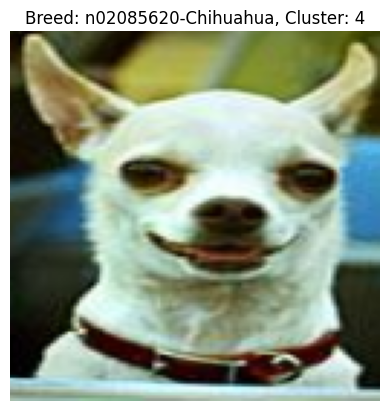

In [2]:
import matplotlib.pyplot as plt

sample_index = 10
print(f"Image shape: {images[sample_index].shape}")
print(f"Label: {labels[sample_index]} (Breed: {le.inverse_transform([labels[sample_index]])[0]})")
print(f"Cluster: {clusters[sample_index]}")

# Test dataset[sample]
plt.imshow(cv2.cvtColor(images[sample_index], cv2.COLOR_BGR2RGB))
plt.title(f"Breed: {le.inverse_transform([labels[sample_index]])[0]}, Cluster: {clusters[sample_index]}")
plt.axis('off')
plt.show()

# Build Model and Train

In [3]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet18_Weights

#  ResNet-18
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(np.unique(labels)))  # # Change last - fully connected

# GPU /CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mixed Precision Training
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

#  EarlyStopping and ReduceLROnPlateau
early_stopping_patience = 5
reduce_lr_patience = 3
early_stopping_counter = 0
best_val_loss = float('inf')

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=reduce_lr_patience, factor=0.2, verbose=True)

# train


In [4]:
num_epochs = 300
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels, clusters in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)
    
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, labels, clusters in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    test_losses.append(running_loss / len(test_loader))
    test_accuracies.append(100 * correct_test / total_test)
    
    # Check for early stop
    val_loss = running_loss / len(test_loader)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), r'..\..\output\models\dog_breed_classifier_best_1.pt')
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

    # Giảm tốc độ học
    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {test_accuracies[-1]}")

Epoch [1/300], Train Loss: 2.9235980115344176, Train Accuracy: 25.828490654939532, Test Loss: 2.393455809354782, Test Accuracy: 35.08165829145729
Epoch [2/300], Train Loss: 1.7686623598462972, Train Accuracy: 47.88754515470394, Test Loss: 2.257228909730911, Test Accuracy: 38.756281407035175
Epoch [3/300], Train Loss: 1.2488541188252031, Train Accuracy: 61.504633265274066, Test Loss: 1.9094586706161498, Test Accuracy: 46.85929648241206
Epoch [4/300], Train Loss: 0.8863759824828287, Train Accuracy: 71.58002198837757, Test Loss: 1.9656139290332795, Test Accuracy: 47.98994974874372
Epoch [5/300], Train Loss: 0.5614023944690599, Train Accuracy: 81.93026543112926, Test Loss: 1.8327444183826447, Test Accuracy: 52.16708542713568
Epoch [6/300], Train Loss: 0.41591168296097514, Train Accuracy: 86.65776660907805, Test Loss: 2.0359446555376053, Test Accuracy: 51.69597989949749
Epoch [7/300], Train Loss: 0.29523238447967487, Train Accuracy: 90.56855662007224, Test Loss: 2.043064676523209, Test Accu

# Save model

In [5]:

torch.save(model.state_dict(), r'..\..\output\models\dog_breed_classifier_1.pt')
print("Model saved to dog_breed_classifier_1.pt")


Model saved to dog_breed_classifier_1.pt


#  Plot Loss và Accuracy

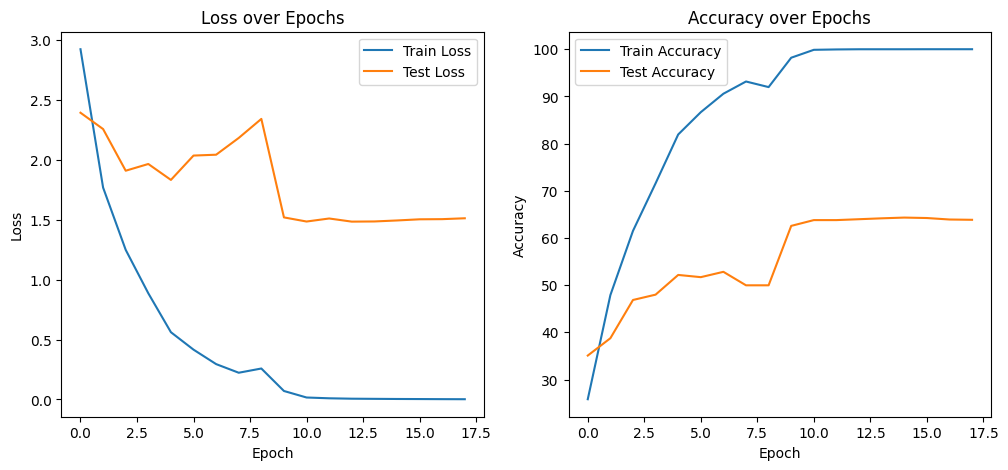

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.savefig(r'..\..\output\classification\Loss_Accuracy.png')
plt.show()


Model loaded from dog_breed_classifier_best_1.pt


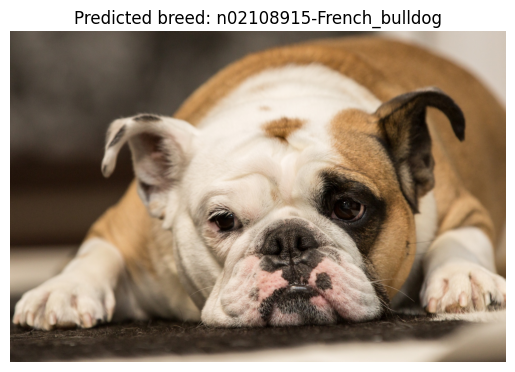

In [16]:
import torch
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
import joblib
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

# Load the number of classes
with open(r'..\..\output\models\num_classes_1.txt', 'r') as f:
    num_classes = int(f.read())

# Load the LabelEncoder
le = joblib.load(r'..\..\output\models\label_encoder_1.joblib')

# Load the best model
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # Change the final fully connected layer
model.load_state_dict(torch.load(r'..\..\output\models\dog_breed_classifier_best_1.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Model loaded from dog_breed_classifier_best_1.pt")

# Predict any image
def predict_image(image_path, model, transform, device):
    # Read and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Prediction
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs.data, 1)
    
    # Convert numeric label to breed name
    predicted_breed = le.inverse_transform(predicted.cpu().numpy())[0]
    return image, predicted_breed

# Transform for prediction
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # For ResNet: input size= [224,224]
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Example prediction
image_path = r'..\..\data\dog_samples.jpg'
image, predicted_breed = predict_image(image_path, model, transform, device)

# Display the image with the predicted label
plt.imshow(image)
plt.title(f'Predicted breed: {predicted_breed}')
plt.axis('off')
plt.show()


In [17]:
# Check for dog classes
unique_labels = df['breed'].unique()
print(f"Number of dog breeds: {len(unique_labels)}")
print(unique_labels[:10])  # 10 index

Number of dog breeds: 120
['n02085620-Chihuahua' 'n02085782-Japanese_spaniel'
 'n02085936-Maltese_dog' 'n02086079-Pekinese' 'n02086240-Shih-Tzu'
 'n02086646-Blenheim_spaniel' 'n02086910-papillon' 'n02087046-toy_terrier'
 'n02087394-Rhodesian_ridgeback' 'n02088094-Afghan_hound']


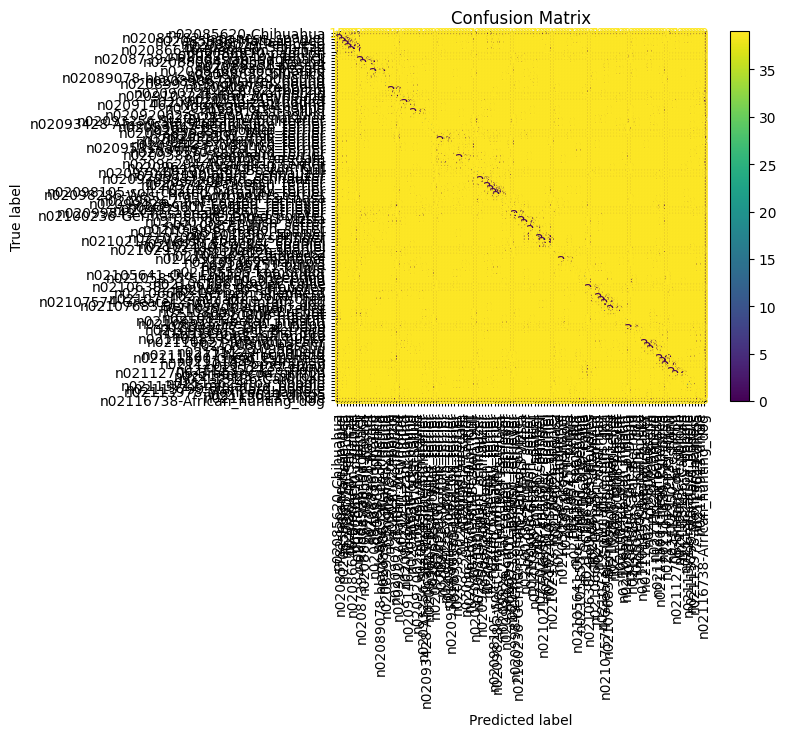

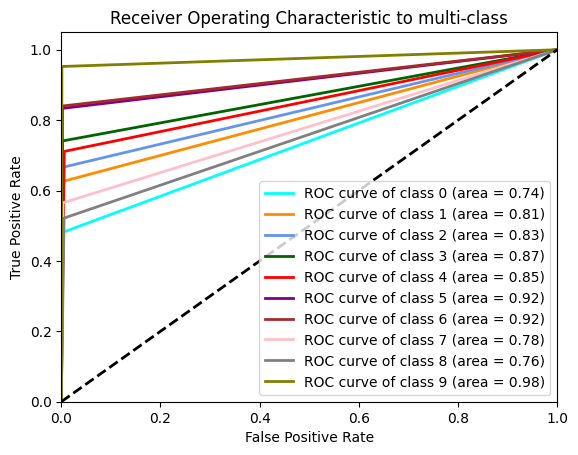

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Tính toán ma trận nhầm lẫn cho tập kiểm tra
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels, clusters in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Hiển thị ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(include_values=True, xticks_rotation='vertical', cmap='viridis')
plt.title("Confusion Matrix")
plt.show()

# Binarize the output
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
y_pred_bin = label_binarize(y_pred, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple', 'brown', 'pink', 'gray', 'olive']

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to multi-class')
plt.legend(loc='lower right')

plt.savefig(r'..\..\output\classification\Confusion_Matrix_and_ROC.png')
plt.show()
